In [923]:
# Setting packages and environments
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
pd.options.display.float_format = '{:.4f}'.format

In [924]:
# Setting function

# Get monthly data from yahoo finance through pandas_datareader 
def GetMonthlyData(ticker,col_name,server='yahoo',start_date='1994-02-18',end_date = '2019-06-29'):
    data = web.DataReader(ticker,server,start_date,end_date).resample('M').last().iloc[:,5:]
    data.interpolate(inplace=True) # Fill NA with preceding and succeeding values
    data.columns = [col_name]
    return data

# Get basic statistic of a fund since inception date
def Pnl_Analyze(fund,inception_date,inception_price):
    # fund -> a pd.DataFrame with columns ['NAV','Benchmark','Rf']
    performance = pd.DataFrame(columns = 
                                   ['Annualized Return','Annualized Volatility',
                                    'Sharpe Ratio','Max Drawdown','Corr','Beta'])

    diff_year = (fund.index[-1] - pd.to_datetime(inception_date)) / np.timedelta64(1,'Y')
    AnnualizedReturn = (fund['NAV'][-1]/inception_price)**(1/float(diff_year)) - 1
    AnnualizedVolatility = np.sqrt(12)*(fund['NAV'].pct_change().dropna().std())
    SharpeRatio = (AnnualizedReturn - fund['Rf'].mean())/AnnualizedVolatility
    MaximumDrawdown = (fund['NAV']/fund['NAV'].cummax()-1).min()
    Corr = np.corrcoef(fund['NAV'].pct_change().dropna(),fund['Benchmark'].pct_change().dropna())[0][1]
    Beta = np.cov(fund['NAV'].pct_change().dropna(),fund['Benchmark'].pct_change().dropna())[0][1]/ (fund['Benchmark'].pct_change().var())
    performance = performance.append({'Annualized Return':AnnualizedReturn,'Annualized Volatility':AnnualizedVolatility,
                        'Sharpe Ratio':SharpeRatio,'Max Drawdown':MaximumDrawdown,
                        'Corr':Corr,'Beta':Beta},ignore_index=True)
    performance.index = ['Since Inception']
    display(performance)

# Get year-detail statistic of a fund and its benchmark
def Pnl_Year_Analyze(fund,initial_price,start_year,end_year):
    # fund -> a pd.DataFrame with columns ['NAV','Benchmark','Rf']
    Performance = pd.DataFrame(columns = 
                               ['Asof',
                                'NAV','NAV Benchmark',
                                'Annual Return','Annual Return Benchmark','Annualized Vol',
                                'Sharpe Ratio','Sharpe Ratio Benchmark',
                                'Max Drawdown','Corr','Beta'])
    fund['NAV'][0] = initial_price
    fund['Benchmark'] = fund['Benchmark']*(fund['NAV'][0]/fund['Benchmark'][0])
    for year in range(start_year,end_year+1):
        FundForSingleYear = fund[fund.index.year == year]
        NAV = FundForSingleYear['NAV'][-1]
        NAV_B = FundForSingleYear['Benchmark'][-1]
        AnnualizedReturn = (FundForSingleYear['NAV'][-1] - FundForSingleYear['NAV'][0])/FundForSingleYear['NAV'][0]
        AnnualizedReturn_B = (FundForSingleYear['Benchmark'][-1] - FundForSingleYear['Benchmark'][0])/FundForSingleYear['Benchmark'][0]
        AnnualizedVolatility = FundForSingleYear['NAV'].pct_change().std() * np.sqrt(12)
        AnnualizedVolatility_B = FundForSingleYear['Benchmark'].pct_change().std() * np.sqrt(12)
        SharpeRatio = (AnnualizedReturn - FundForSingleYear['Rf'].mean())/ AnnualizedVolatility
        SharpeRatio_B = (AnnualizedReturn_B - FundForSingleYear['Rf'].mean())/ AnnualizedVolatility_B
        MaximumDrawdown = (FundForSingleYear['NAV']/FundForSingleYear['NAV'].cummax() - 1).min()
        Corr = np.corrcoef(FundForSingleYear['NAV'].pct_change().dropna(),FundForSingleYear['Benchmark'].pct_change().dropna())[0][1]
        Beta = np.cov(FundForSingleYear['NAV'].pct_change().dropna(),FundForSingleYear['Benchmark'].pct_change().dropna())[0][1]/ (FundForSingleYear['Benchmark'].pct_change().var())
        Performance = Performance.append({'Asof':str(year),'NAV':NAV,
                        'NAV Benchmark':NAV_B,
                        'Annual Return':AnnualizedReturn,
                        'Annual Return Benchmark':AnnualizedReturn_B,
                        'Annualized Vol':AnnualizedVolatility,
                        'Sharpe Ratio':SharpeRatio,
                        'Sharpe Ratio Benchmark':SharpeRatio_B,
                        'Max Drawdown':MaximumDrawdown,
                        'Corr': Corr,
                        'Beta':Beta},ignore_index=True)
    Performance.index = Performance.Asof
    Performance = Performance.iloc[:,1:]
    
    return Performance

# Year detail data visualization
def Pnl_Year_Visualize(Peformance):
    plt.figure(figsize=(30,15))
    plt.tight_layout()
    index = Performance.index
    compare_list = [('NAV','NAV Benchmark'),('Annual Return','Annual Return Benchmark'),('Sharpe Ratio','Sharpe Ratio Benchmark')]
    for i in range(1,4):
        plt.subplot(2,2,i)
        plt.plot(index,Performance[compare_list[i-1][0]],linewidth = 2, linestyle = '-')
        plt.plot(index,Performance[compare_list[i-1][1]],color = 'green',linewidth = 2, linestyle = '-.')
        plt.title(compare_list[i-1][0],fontsize=25)
        plt.legend(['Fund','Benchmark'],fontsize = 20)
    
    plt.subplot(2,2,4)
    plt.plot(index,Performance['Max Drawdown'])
    plt.fill_between(index,0,Performance['Max Drawdown'])
    plt.title('Maximum Drawdown',fontsize=25)
    plt.legend(['Fund'],fontsize = 20)
    plt.show()

# Option hedging strategy
def OptionHedging(portfolio,OTM,ExpiryMonth):
    # portfolio -> a pd.DataFrame with columns ['Unhedged','AssetPrice','Rf','Vol']
    # Time unit -> year
    NormalRatio = portfolio['AssetPrice'][0]/portfolio['Unhedged'][0]
    portfolio['Unhedged'] = portfolio['Unhedged']*NormalRatio
    T = ExpiryMonth/12
    Beta_list = [0]*24
    for i in range(24,len(portfolio)):
        portfolio_temp = portfolio[i-24:i]
        beta_temp = np.cov(portfolio_temp['Unhedged'].pct_change().dropna(),
                           portfolio_temp['AssetPrice'].pct_change().dropna())[0][1]/(portfolio_temp['AssetPrice'].pct_change().var())
        Beta_list.append(beta_temp)
    portfolio['Beta'] = Beta_list
    portfolio['Vol'] = portfolio['Vol'].shift(ExpiryMonth)
    portfolio['StrikePrice'] = (portfolio['AssetPrice']*OTM).shift(ExpiryMonth)
    portfolio['d1'] = (np.log(portfolio['AssetPrice']/portfolio['StrikePrice'])+ 
                       (portfolio['Rf']+(portfolio['Vol']**2)/2)*T)/(portfolio['Vol']*np.sqrt(T))
    portfolio['d2'] = portfolio['d1'] - portfolio['Vol']*np.sqrt(T)
    portfolio['OptionPrice'] = portfolio['StrikePrice']*np.exp(-portfolio['Rf']*T)*norm.cdf(-portfolio['d2'])- portfolio['AssetPrice']*norm.cdf(-portfolio['d1'])
    portfolio['ExecuteProfit'] = np.maximum(portfolio['StrikePrice'] - portfolio['AssetPrice'],0)
    portfolio['NetProfit'] = (portfolio['ExecuteProfit']  - portfolio['OptionPrice']).cumsum()
    portfolio.fillna(0,inplace=True)
    portfolio['Hedged'] = portfolio['Unhedged'] + portfolio['Beta']*portfolio['NetProfit']
    portfolio['Hedged'] = portfolio['Hedged']/NormalRatio
    portfolio['Unhedged'] = portfolio['Unhedged']/NormalRatio
    
    return portfolio

# Normalization function in orthogonalization
def normalize(x):
    return x / np.sqrt(x.dot(x))

,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Corr,Beta
Since Inception,0.0965,0.2435,0.2989,-0.6803,0.4531,0.7590


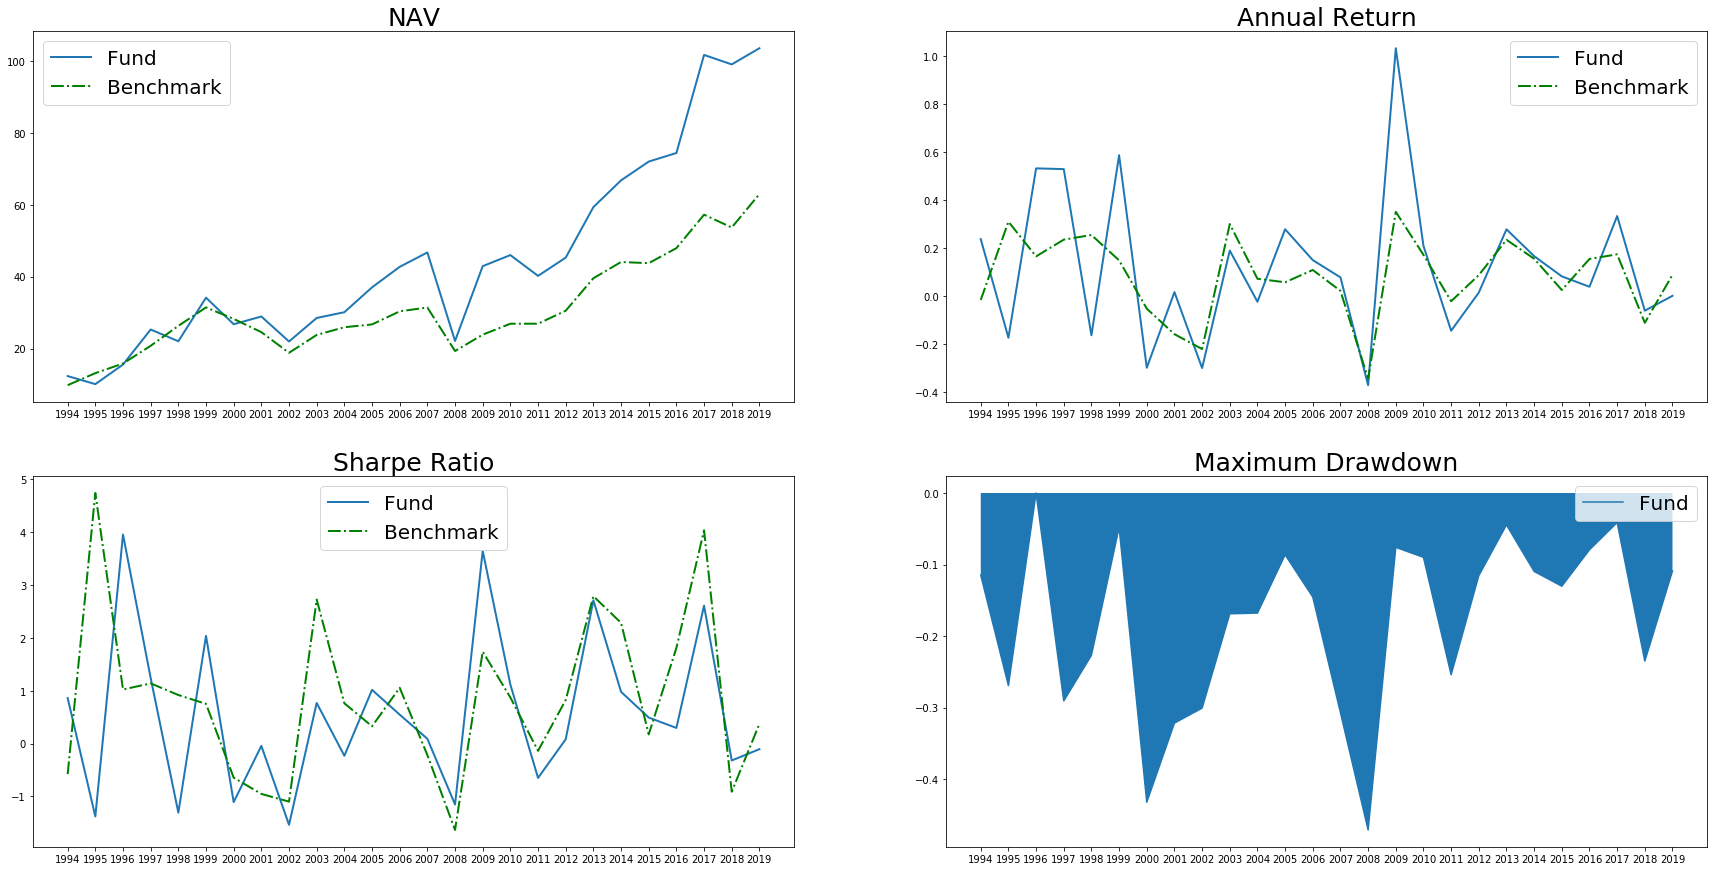

In [925]:
'''
1. Provide the following statistics for the UPAMC All Weather-A fund (0P00006AC3.TW) since inception: 
annualized return and volatility, Sharpe ratio, max. drawdown, correlation and beta to S&P 500.
'''
# Get monthly data of fund, benchmark, and risk-free rate
Fund = GetMonthlyData('0P00006AC3.TW','Fund')
SP500 = GetMonthlyData('^GSPC','Benchmark')
Rf = GetMonthlyData('^IRX','Rf')/100
fund = pd.concat([Fund,SP500,Rf],axis=1) 
fund.columns = ['NAV','Benchmark','Rf']

# Basic statistic calculation
Pnl_Analyze(fund,'1994-02-18',10)

# Detial statstic calculation and visualization
fund_year_pnl = Pnl_Year_Analyze(fund,10,1994,2019)
Pnl_Year_Visualize(fund_year_pnl)

In [926]:
'''
2. Backtest a long put option hedge for the strategy in the previous point, 
aiming at reducing the beta of the hedged strategy to S&P 500 by 50%. 
In order to do that, simulate rolling monthly an OTM put for protection. 
The parameters to be chosen are: i) moneyness of OTM put (95%, 90%, etc.), and 
ii) option expiry (1 month, 3 months, etc.). 
Compare Sharpe ratio and max. drawdown of hedged and unhedged strategies.
'''
# Getting monthly data of Vol
Vol = GetMonthlyData('^VIX','Vol')/100

# Setting parameters
OTM_list = [0.98,0.95,0.90]
ExpiryMonth_list = [1,3]

# For loop to generate different combination of beta hedging strategies
for OTM in OTM_list:
    for ExpiryMonth in ExpiryMonth_list:
        Portfolio_SP500 = pd.concat([Fund,SP500, Rf, Vol],axis=1)
        Portfolio_SP500.columns = ['Unhedged','AssetPrice','Rf','Vol']
        # Option strategy
        strategy = OptionHedging(Portfolio_SP500,OTM,ExpiryMonth) 
        # The first two years are unhedged, should not be considered when do comparsion
        strategy_beta = strategy.iloc[24:,:]
        Beta_Hedged = np.cov(strategy_beta['Hedged'].pct_change().dropna(),strategy_beta['AssetPrice'].pct_change().dropna())[0][1]/ (strategy_beta['AssetPrice'].pct_change().var())
        Beta_Unhedged = np.cov(strategy_beta['Unhedged'].pct_change().dropna(),strategy_beta['AssetPrice'].pct_change().dropna())[0][1]/ (strategy_beta['AssetPrice'].pct_change().var())
        print('OTM Ratio of %.2f'%OTM,'and T',ExpiryMonth,'month(s) has hedged beta %.2f'% Beta_Hedged)
print('Orignal unhedged beta %.2f'%Beta_Unhedged)

OTM Ratio of 0.98 and T 1 month(s) has hedged beta 0.12
OTM Ratio of 0.98 and T 3 month(s) has hedged beta 3.29
OTM Ratio of 0.95 and T 1 month(s) has hedged beta 0.52
OTM Ratio of 0.95 and T 3 month(s) has hedged beta 28.50
OTM Ratio of 0.90 and T 1 month(s) has hedged beta 1.07
OTM Ratio of 0.90 and T 3 month(s) has hedged beta -3.31
Orignal unhedged beta 0.77


In [927]:
# Get basic statstics of hedged portfolio
Portfolio_SP500 = pd.concat([Fund,SP500, Rf, Vol],axis=1)
Portfolio_SP500.columns = ['Unhedged','AssetPrice','Rf','Vol']
strategy = OptionHedging(Portfolio_SP500,0.95,1) 
fund_hedged = strategy[['Hedged','AssetPrice','Rf']]
fund_hedged.columns = ['NAV','Benchmark','Rf']
Pnl_Analyze(fund_hedged,'1994-02-18',10)

,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Corr,Beta
Since Inception,0.0817,2.2207,0.0261,-1.0515,0.0341,0.5214


In [928]:
'''
3. Using regression modeling, evaluate the sensitivity (beta) of the hedged strategy returns 
to the following market risk factors: gold (GLD), oil (USO), commodities (DBC), real estate (VNQ), 
US equities (SPY), world equities (VEU), emerging markets (EEM), volatility (^VIX), 
US 10 year interest rates (^TNX), US dollar (UUP).
Provide two sets of betas: a) betas to individual factors (simple linear regression), 
betas on multiple factors (multiple linear regression).
'''

tickers_regression = ['GLD','USO','DBC','VNQ','SPY','VEU','EEM','^VIX','^TNX','UUP']
portfolio_regression = {}
# Get monthly data of mark factors
for ticker in tickers_regression:
    if ticker[0] == '^': portfolio_regression[ticker[1:]] = GetMonthlyData(ticker,ticker[1:])
    else: portfolio_regression[ticker] = GetMonthlyData(ticker,ticker)
factors = pd.DataFrame()
# Single linear regression
for (ticker,data) in portfolio_regression.items(): 
    factors = pd.concat([factors, data],axis=1)
    Month_return = pd.concat([Fund.pct_change(),data.pct_change()], axis=1).dropna()
    results = smf.ols('Fund ~' + ticker, data=Month_return).fit()
    print(ticker,'Beta: %.4f' % results.params[1])
factor_return = factors.pct_change().dropna()
corr = factor_return.corr()
corr.style.background_gradient(cmap='coolwarm')

GLD Beta: 0.1216
USO Beta: 0.2219
DBC Beta: 0.4300
VNQ Beta: 0.3081
SPY Beta: 0.7635
VEU Beta: 0.7004
EEM Beta: 0.5779
VIX Beta: -0.0997
TNX Beta: 0.1551
UUP Beta: -0.8503


,GLD,USO,DBC,VNQ,SPY,VEU,EEM,VIX,TNX,UUP
GLD,1,0.166944,0.408786,0.0831466,0.0316376,0.19102,0.2739,-0.0161724,-0.313358,-0.436943
USO,0.166944,1,0.869088,0.214136,0.485043,0.530318,0.516317,-0.277927,0.357814,-0.449364
DBC,0.408786,0.869088,1,0.306787,0.527151,0.621439,0.622843,-0.335227,0.259885,-0.616343
VNQ,0.0831466,0.214136,0.306787,1,0.715863,0.682339,0.616979,-0.458855,-0.0456455,-0.380819
SPY,0.0316376,0.485043,0.527151,0.715863,1,0.887979,0.803413,-0.699906,0.288168,-0.480333
VEU,0.19102,0.530318,0.621439,0.682339,0.887979,1,0.942679,-0.656121,0.193899,-0.704048
EEM,0.2739,0.516317,0.622843,0.616979,0.803413,0.942679,1,-0.585506,0.159668,-0.670795
VIX,-0.0161724,-0.277927,-0.335227,-0.458855,-0.699906,-0.656121,-0.585506,1,-0.137552,0.322063
TNX,-0.313358,0.357814,0.259885,-0.0456455,0.288168,0.193899,0.159668,-0.137552,1,0.000788952
UUP,-0.436943,-0.449364,-0.616343,-0.380819,-0.480333,-0.704048,-0.670795,0.322063,0.000788952,1


In [929]:
# Gram-Schmidt orthogonalization 
n = factor_return.count(axis='columns')[0]

factor_return.iloc[:, 0] = normalize(factor_return.iloc[:, 0])

for i in range(1, n):
    factor_return_i = factor_return.iloc[:, i]
    for j in range(0, i):
        factor_return_j = factor_return.iloc[:, j]
        t = factor_return_i.dot(factor_return_j)
        factor_return_i = factor_return_i - t * factor_return_j
    factor_return.iloc[:, i] = normalize(factor_return_i)

corr = factor_return.corr()
display(corr.style.background_gradient(cmap='coolwarm'))
Month_return = pd.concat([Fund.pct_change(),factor_return],axis=1).dropna()
# Multiple linear regression after orthogonalization 
results = smf.ols('Fund ~ GLD+USO+DBC+VNQ+SPY+VEU+EEM+VIX+TNX+UUP' , data=Month_return).fit()
print('Beta:')
results.params[1:]

,GLD,USO,DBC,VNQ,SPY,VEU,EEM,VIX,TNX,UUP
GLD,1,0.00928673,0.00217211,-0.0136245,-0.0290978,0.0209306,-0.00418204,-0.0331214,0.00340918,-0.00783624
USO,0.00928673,1,-0.00142502,0.00893843,0.0190897,-0.0137316,0.00274365,0.0217294,-0.00223661,0.005141
DBC,0.00217211,-0.00142502,1,0.00209065,0.00446498,-0.00321173,0.000641722,0.00508238,-0.000523129,0.00120245
VNQ,-0.0136245,0.00893843,0.00209065,1,-0.0280065,0.0201456,-0.0040252,-0.0318792,0.00328132,-0.00754234
SPY,-0.0290978,0.0190897,0.00446498,-0.0280065,1,0.0430247,-0.00859658,-0.0680841,0.00700789,-0.0161081
VEU,0.0209306,-0.0137316,-0.00321173,0.0201456,0.0430247,1,0.00618367,0.0489741,-0.0050409,0.0115868
EEM,-0.00418204,0.00274365,0.000641722,-0.0040252,-0.00859658,0.00618367,1,-0.0097853,0.0010072,-0.00231512
VIX,-0.0331214,0.0217294,0.00508238,-0.0318792,-0.0680841,0.0489741,-0.0097853,1,0.00797693,-0.0183355
TNX,0.00340918,-0.00223661,-0.000523129,0.00328132,0.00700789,-0.0050409,0.0010072,0.00797693,1,0.00188727
UUP,-0.00783624,0.005141,0.00120245,-0.00754234,-0.0161081,0.0115868,-0.00231512,-0.0183355,0.00188727,1


Beta:


GLD    0.0456
USO    0.2565
DBC    0.1452
VNQ    0.1887
SPY    0.2464
VEU    0.1957
EEM    0.1404
VIX    0.0829
TNX   -0.0313
UUP    0.1125
dtype: float64